#Conectamos a google drive e importamos librerias

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import pandas as pd
!pip install pandas_summary
from pandas_summary import DataFrameSummary
import numpy as np
import datetime
!pip install isoweek
from isoweek import Week
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
!pip install sklearn_pandas
from sklearn_pandas import DataFrameMapper

# Para importar el Helper
%cd "/gdrive/Shareddrives/Redes neuronales/TP2"
!pip install import-ipynb
import import_ipynb
from Helper import *

/gdrive/Shareddrives/Redes neuronales/TP2
  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-py3-none-any.whl size=2975 sha256=c37c3ac052e1c5612f586aa058450ea3bbac51c9a4e3f4a23514c7144617330d
  Stored in directory: /root/.cache/pip/wheels/b1/5e/dc/79780689896a056199b0b9f24471e3ee184fbd816df355d5f0
Successfully built import-ipynb
importing Jupyter notebook from Helper.ipynb


# Análisis de los datasets

A continuación vamos a explorar todos los dataset de train, test y stores dados oficialmente por la competencia, además de algunos datasets subidos al Kaggle por otros participantes.

In [ ]:
PATH = "/gdrive/Shareddrives/Redes neuronales/TP2/dataset/"

In [ ]:
table_names = ['train', 'store', 'store_states', 'state_names', 'googletrend', 'weather', 'test'] 
train, store, store_states, state_names, googletrend, weather, test = dfs = [pd.read_csv(PATH + fname+'.csv', low_memory=False) for fname in table_names]

- train: Training set dado por la competencia. Contiene información de la tienda a diario.

- store: Listado de las tiendas. Información general sobre la tienda, incluida la competencia

- store_states: Localización del estado Aleman en el que se encuentran las tiendas.

- state_names: Lista de los nombres de los estados Alemanes.

- googletrend: Tendencia de ciertas palabras clave de Google a lo largo del tiempo, que los usuarios encuentran que se correlacionan bien con los datos dados. Estos son datos de tendencias para una semana / estado en particular.

- weather: Clima para cada estado

- test: Testing set dado por la competencia. Trae las mismas variables que el train, solo que sin la columna 'sales' ni 'customers'.

#### Se muestra la tabla de train

La mayoría de los campos se explican por sí mismos. Las siguientes son descripciones para aquellos que no lo son.

- Id: un Id que representa un dúplex (Store, Date) dentro del conjunto de prueba.

- Tienda: una identificación única para cada tienda.

- Ventas: el volumen de negocios de un día determinado (esto es lo que está prediciendo).

- Clientes: el número de clientes en un día determinado.

- Abierta: un indicador de si la tienda estaba abierta: 0 = cerrada, 1 = abierta.

- Promo: indica si una tienda está ejecutando una promoción ese día.

- StateHoliday: indica un feriado estatal.

- SchoolHoliday: indica si el (Store, Date) se vio afectado por el cierre de las escuelas públicas.

In [ ]:
display(train.head())
display(DataFrameSummary(train).summary())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
count,1.01721e+06,1.01721e+06,NaN,1.01721e+06,1.01721e+06,1.01721e+06,1.01721e+06,NaN,1.01721e+06
mean,558.43,3.99834,NaN,5773.82,633.146,0.830107,0.381515,NaN,0.178647
std,321.909,1.99739,NaN,3849.93,464.412,0.375539,0.485759,NaN,0.383056
min,1,1,NaN,0,0,0,0,NaN,0
25%,280,2,NaN,3727,405,1,0,NaN,0
50%,558,4,NaN,5744,609,1,0,NaN,0
75%,838,6,NaN,7856,837,1,1,NaN,0
max,1115,7,NaN,41551,7388,1,1,NaN,1
counts,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209
uniques,1115,7,942,21734,4086,2,2,4,2


Vemos que no hay dantos faltantes ya que missing es 0 para cada una de las características y el counts es el mismo para todos los campos.

In [ ]:
train['StateHoliday'].value_counts()

0    986159
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

StateHoliday - indica un feriado estatal. Normalmente, todas las tiendas, con pocas excepciones, están cerradas los días festivos estatales. Se tiene en cuenta que todas las escuelas están cerradas los días festivos y fines de semana. 
- a = festivo
- b = festivo de Pascua
- c = Navidad
- 0 = Ninguno

#### Se muestra la tabla de store

Descripción de los campos:

- StoreType: diferencia entre 4 modelos de tienda diferentes: a, b, c, d.

- Assortment: describe variedad de elementos a vender: a = básico, b = extra, c = extendido.

- CompetitionDistance: distancia en metros hasta la tienda competidora más cercana.

- CompetitionOpenSince [Month / Year]: proporciona el año y el mes aproximados del momento en que se abrió el competidor más cercano.

- Promo2: es una promoción continua y consecutiva para algunas tiendas: 0 = la tienda no participa, 1 = la tienda participa.

- Promo2Since [Year / Week]: describe el año y la semana calendario en que la tienda comenzó a participar en Promo2.

- PromoInterval: describe los intervalos consecutivos en que se inicia Promo2, nombrando los meses en que la promoción se inicia de nuevo. P.ej. "Febrero, mayo, agosto, noviembre" significa que cada ronda comienza en febrero, mayo, agosto, noviembre de cualquier año para esa tienda.

In [ ]:
display(store.head())
display(DataFrameSummary(store).summary())

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
count,1115,NaN,NaN,1112,761,761,1115,571,571,NaN
mean,558,NaN,NaN,5404.9,7.2247,2008.67,0.512108,23.5954,2011.76,NaN
std,322.017,NaN,NaN,7663.17,3.21235,6.19598,0.500078,14.142,1.67494,NaN
min,1,NaN,NaN,20,1,1900,0,1,2009,NaN
25%,279.5,NaN,NaN,717.5,4,2006,0,13,2011,NaN
50%,558,NaN,NaN,2325,8,2010,1,22,2012,NaN
75%,836.5,NaN,NaN,6882.5,10,2013,1,37,2013,NaN
max,1115,NaN,NaN,75860,12,2015,1,50,2015,NaN
counts,1115,1115,1115,1112,761,761,1115,571,571,571
uniques,1115,4,3,654,12,23,2,24,7,3


Analisis de algunos campos:

Vemos que a 3 tiendas le faltan datos como:
- CompetitionDistance
- CompetitionOpenSinceMonth
- CompetitionOpenSinceYear




In [ ]:
store['Promo2'].value_counts()[0]*100/len(store['Promo2'])

48.789237668161434

El 48.78 \% de los datos al no tener Promo2, van a estar vacíos en:

- Promo2SinceWeek	
- Promo2SinceYear	
- PromoInterval

In [ ]:
store['StoreType'].value_counts()

a    602
d    348
c    148
b     17
Name: StoreType, dtype: int64

In [ ]:
store['PromoInterval'].value_counts()

Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: PromoInterval, dtype: int64

#### Se muestra la tabla de store_states

- State: Acronimo del estado de alemania donde esta la tienda. 

In [ ]:
display(store_states.head(20))
display(DataFrameSummary(store_states).summary())

,Store,State
0,1,HE
1,2,TH
2,3,NW
3,4,BE
4,5,SN
5,6,SN
6,7,SH
7,8,SH
8,9,NW
9,10,"HB,NI"


,Store,State
count,1115,NaN
mean,558,NaN
std,322.017,NaN
min,1,NaN
25%,279.5,NaN
50%,558,NaN
75%,836.5,NaN
max,1115,NaN
counts,1115,1115
uniques,1115,12


Vemos que hay doce posibles estados para las tiendas y no hay ningun dato faltante.

#### Se muestra la tabla state_names

- StateName: Nombre completo del estado de Alemania.

In [ ]:
display(state_names.head(20))
display(DataFrameSummary(state_names).summary())

,StateName,State
0,BadenWuerttemberg,BW
1,Bayern,BY
2,Berlin,BE
3,Brandenburg,BB
4,Bremen,HB
5,Hamburg,HH
6,Hessen,HE
7,MecklenburgVorpommern,MV
8,Niedersachsen,"HB,NI"
9,NordrheinWestfalen,NW


,StateName,State
count,16,16
unique,16,16
top,Hessen,BB
freq,1,1
counts,16,16
uniques,16,16
missing,0,0
missing_perc,0%,0%
types,unique,unique


#### Se muestra la tabla de googletrend

- week: Semana en la que se esta evaluando el googletrend.

- trend: Cantidad de busquedas de las palabras que llevan al store esa semana.

In [ ]:
display(googletrend)
display(DataFrameSummary(googletrend).summary())

,file,week,trend
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95
2,Rossmann_DE_SN,2012-12-16 - 2012-12-22,91
3,Rossmann_DE_SN,2012-12-23 - 2012-12-29,48
4,Rossmann_DE_SN,2012-12-30 - 2013-01-05,67
...,...,...,...
2067,Rossmann_DE_SL,2015-08-30 - 2015-09-05,95
2068,Rossmann_DE_SL,2015-09-06 - 2015-09-12,47
2069,Rossmann_DE_SL,2015-09-13 - 2015-09-19,80
2070,Rossmann_DE_SL,2015-09-20 - 2015-09-26,57


,file,week,trend
count,NaN,NaN,2072
mean,NaN,NaN,63.8142
std,NaN,NaN,12.6502
min,NaN,NaN,0
25%,NaN,NaN,55
50%,NaN,NaN,64
75%,NaN,NaN,72
max,NaN,NaN,100
counts,2072,2072,2072
uniques,14,148,68


#### Se muestra la tabla weather

In [ ]:
display(weather)
display(DataFrameSummary(weather[['Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'Precipitationmm']]).summary())

,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Sea_Level_PressurehPa,Mean_Sea_Level_PressurehPa,Min_Sea_Level_PressurehPa,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,NordrheinWestfalen,2013-01-01,8,4,2,7,5,1,94,87,65,1013,1005,1001,31.0,12.0,4.0,39,26,58.0,5.08,6.0,Rain,215
1,NordrheinWestfalen,2013-01-02,7,4,1,5,3,2,93,85,78,1028,1022,1014,31.0,14.0,10.0,24,16,NaN,0.00,6.0,Rain,225
2,NordrheinWestfalen,2013-01-03,11,8,6,10,8,4,100,93,77,1035,1030,1026,31.0,8.0,2.0,26,21,NaN,1.02,7.0,Rain,240
3,NordrheinWestfalen,2013-01-04,9,9,8,9,9,8,100,94,87,1036,1035,1034,11.0,5.0,2.0,23,14,NaN,0.25,7.0,Rain,263
4,NordrheinWestfalen,2013-01-05,8,8,7,8,7,6,100,94,87,1035,1034,1033,10.0,6.0,3.0,16,10,NaN,0.00,7.0,Rain,268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15835,Saarland,2015-09-13,21,17,12,16,14,12,100,88,68,1015,1010,1005,31.0,15.0,10.0,27,10,50.0,1.02,7.0,Rain,113
15836,Saarland,2015-09-14,18,14,11,15,12,7,99,85,61,1009,1005,1004,31.0,13.0,4.0,32,16,53.0,9.91,5.0,Rain-Thunderstorm,213
15837,Saarland,2015-09-15,16,12,9,11,8,7,93,77,62,1010,1008,1004,31.0,12.0,10.0,34,14,NaN,0.00,5.0,Rain,193
15838,Saarland,2015-09-16,19,15,11,16,13,10,97,90,75,1004,999,995,31.0,10.0,4.0,32,14,45.0,20.07,7.0,Rain-Thunderstorm,147


,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,CloudCover,Precipitationmm
count,15840,15840,15840,15840,15840,15840,15840,15840,14667,15840
mean,14.6441,10.389,6.19899,93.6596,74.2829,50.1586,22.7666,11.9722,5.55131,0.831718
std,8.64601,7.37926,6.52639,7.67853,13.4866,19.9602,8.98862,5.87284,1.68771,2.51351
min,-11,-13,-15,44,30,4,3,2,0,0
25%,8,4,1,90.75,65,34,16,8,5,0
50%,15,11,7,94,76,49,21,11,6,0
75%,21,16,11,100,85,66,27,14,7,0.25
max,39,31,24,100,100,100,101,53,8,58.93
counts,15840,15840,15840,15840,15840,15840,15840,15840,14667,15840
uniques,51,45,40,53,71,93,44,29,9,41


In [ ]:
weather.columns

Index(['file', 'Date', 'Max_TemperatureC', 'Mean_TemperatureC',
       'Min_TemperatureC', 'Dew_PointC', 'MeanDew_PointC', 'Min_DewpointC',
       'Max_Humidity', 'Mean_Humidity', 'Min_Humidity',
       'Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa',
       'Min_Sea_Level_PressurehPa', 'Max_VisibilityKm', 'Mean_VisibilityKm',
       'Min_VisibilitykM', 'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h',
       'Max_Gust_SpeedKm_h', 'Precipitationmm', 'CloudCover', 'Events',
       'WindDirDegrees'],
      dtype='object')

Suponemos que CloudCover posee elementos vaciós ya que al no ser un día nublado, no se le prestó atención al tema



#Preprocesamiento de datos

## Missing data

Se verifican cuales son las columnas que presentan datos faltantes

In [ ]:
for i, df in enumerate(dfs):
    print(table_names[i], get_missing_columns(df))

train []
store ['CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']
store_states []
state_names []
googletrend []
weather ['Max_VisibilityKm', 'Mean_VisibilityKm', 'Min_VisibilitykM', 'Max_Gust_SpeedKm_h', 'CloudCover', 'Events']
test ['Open']


Vamos a tener que tratar los campos faltantes para las tablas store, weather y test.

#### Tratamiento test

Si no es domingo (7), y no tenemos datos suponemos que el local esta abierto (ya que suele abrir todos los dias excepto el domingo)

In [ ]:
test.loc[test['Open'].isna(), 'Open']

479     NaN
1335    NaN
2191    NaN
3047    NaN
4759    NaN
5615    NaN
6471    NaN
7327    NaN
8183    NaN
9039    NaN
10751   NaN
Name: Open, dtype: float64

In [ ]:
np.unique(test['DayOfWeek'])

array([1, 2, 3, 4, 5, 6, 7])

In [ ]:
test.loc[test['Open'].isna(), 'Open'] = (test[test['Open'].isna()]['DayOfWeek'] != 7)*1.0

#### Tratamiento store

Pasa las fechas más antiguas que 1990 y las faltantes a 1990. Suponemos que es porque como es una fecha faltante, se supone que paso hace mucho tiempo

In [ ]:
store['CompetitionOpenSinceYear'].min()

1900.0

In [ ]:
store.loc[store['CompetitionOpenSinceYear'].isna() | (store['CompetitionOpenSinceYear']<1990), 'CompetitionOpenSinceYear'] = np.int32(1990)
store.loc[store['CompetitionOpenSinceMonth'].isna() | (store['CompetitionOpenSinceYear']<1990), 'CompetitionOpenSinceMonth'] = np.int32(1)

Al evaluar la distancia con otras tiendas, si no tengo la distancia, supongo que no hay. Como si estuviera lejos, lo ponemos a la distancia máxima.

In [ ]:
print(store['CompetitionDistance'].max(), store['CompetitionDistance'].mean(), store['CompetitionDistance'].min())
store.loc[store['CompetitionDistance'].isna(), 'CompetitionDistance'] = store['CompetitionDistance'].max()

75860.0 5404.901079136691 20.0


Si no tiene Promo2 entonces la semana en donde empezo es cero. Esto será tratado como categórica por eso tiene sentido. A los valores donde aparece nan se le pone 0

In [ ]:
np.unique(store['Promo2SinceWeek'])

array([ 1.,  5.,  6.,  9., 10., 13., 14., 18., 22., 23., 26., 27., 28.,
       31., 35., 36., 37., 39., 40., 44., 45., 48., 49., 50., nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

Como se noto antes, al no existir Promo2, los campos Promo2SinceWeek, Promo2SinceYear y PromoInterval también van a estar vacios, por eso hacemos lo mismo y los nan los  pasamos a 0.

In [ ]:
store.loc[store['Promo2SinceWeek'].isna() & (store['Promo2'] == 0), 'Promo2SinceWeek'] = np.int32(1)
store.loc[store['Promo2SinceYear'].isna() & (store['Promo2'] == 0), 'Promo2SinceYear'] = np.int32(1990)
store.loc[store['PromoInterval'].isna() & (store['Promo2'] == 0), 'PromoInterval'] = '-'

#### Tratamiento weather

Supongo que son dias climáticamente tranquilos (**de todas formas no se usaran para la predicción**). Está reemplazando los diás que no tienen datos por días climáticamente lindos, ya que asumimos que si no hubieran sido días así se habría hecho comentado sobre la lluvia, visibilidad u otras cuestiones.

In [ ]:
np.unique(weather['Max_VisibilityKm'])

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 13.,
       14., 16., 18., 19., 21., 23., 24., 26., 27., 29., 31., nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

In [ ]:
weather.describe()

,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Sea_Level_PressurehPa,Mean_Sea_Level_PressurehPa,Min_Sea_Level_PressurehPa,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,WindDirDegrees
count,15840.000000,15840.000000,15840.000000,15840.000000,15840.000000,15840.000000,15840.000000,15840.000000,15840.000000,15840.000000,15840.000000,15840.000000,15459.000000,15459.000000,15459.000000,15840.000000,15840.000000,3604.000000,15840.000000,14667.000000,15840.000000
mean,14.644129,10.388952,6.198990,8.587816,6.205808,3.626136,93.659596,74.282891,50.158586,1018.532197,1015.299747,1012.307955,24.057572,12.239796,7.025163,22.766604,11.972222,48.864317,0.831718,5.551306,175.896717
std,8.646012,7.379260,6.526391,6.244780,6.086768,6.128390,7.678530,13.486552,19.960216,7.788720,8.123311,8.600585,8.976799,5.067944,4.980602,8.988618,5.872844,13.026954,2.513506,1.687710,101.588872
min,-11.000000,-13.000000,-15.000000,-14.000000,-15.000000,-73.000000,44.000000,30.000000,4.000000,976.000000,974.000000,970.000000,0.000000,0.000000,0.000000,3.000000,2.000000,21.000000,0.000000,0.000000,-1.000000
25%,8.000000,4.000000,1.000000,4.000000,2.000000,-1.000000,90.750000,65.000000,34.000000,1014.000000,1010.000000,1007.000000,14.000000,10.000000,3.000000,16.000000,8.000000,39.000000,0.000000,5.000000,80.000000
50%,15.000000,11.000000,7.000000,9.000000,7.000000,4.000000,94.000000,76.000000,49.000000,1019.000000,1016.000000,1013.000000,31.000000,11.000000,7.000000,21.000000,11.000000,48.000000,0.000000,6.000000,202.000000
75%,21.000000,16.000000,11.000000,13.000000,11.000000,8.000000,100.000000,85.000000,66.000000,1024.000000,1021.000000,1018.000000,31.000000,14.000000,10.000000,27.000000,14.000000,55.000000,0.250000,7.000000,256.000000
max,39.000000,31.000000,24.000000,25.000000,20.000000,19.000000,100.000000,100.000000,100.000000,1043.000000,1040.000000,1038.000000,31.000000,31.000000,31.000000,101.000000,53.000000,111.000000,58.930000,8.000000,360.000000


In [ ]:
weather.loc[weather['Max_VisibilityKm'].isna(), 'Max_VisibilityKm'] = weather['Max_VisibilityKm'].max()
weather.loc[weather['Mean_VisibilityKm'].isna(), 'Mean_VisibilityKm'] = weather['Mean_VisibilityKm'].max()
weather.loc[weather['Min_VisibilitykM'].isna(), 'Min_VisibilitykM'] = weather['Min_VisibilitykM'].max()
weather.loc[weather['Max_Gust_SpeedKm_h'].isna(), 'Max_Gust_SpeedKm_h'] = weather['Max_Gust_SpeedKm_h'].min()
weather.loc[weather['CloudCover'].isna(), 'CloudCover'] = weather['CloudCover'].min()
weather.loc[weather['Events'].isna(), 'Events'] = 'Sunny'

#### Verificación

Nos fijamos que se hayan completado las columnas con datos faltantes

In [ ]:
for i, df in enumerate(dfs):
    print(table_names[i], get_missing_columns(df))

train []
store []
store_states []
state_names []
googletrend []
weather []
test []


## Transformación de fechas a datetime

Cambiamos el tipo de dato en aquellas columnas donde aparecen fechas, para poder extraer caracteristicas significantes y así entrenar correctamente el modelo.

In [ ]:
type(store['CompetitionOpenSinceYear'][0])

numpy.float64

In [ ]:
store['CompetitionOpenSinceYear'] = store['CompetitionOpenSinceYear'].astype(np.int32)
store['CompetitionOpenSinceMonth'] = store['CompetitionOpenSinceMonth'].astype(np.int32)
store['Promo2SinceWeek'] = store['Promo2SinceWeek'].astype(np.int32)
store['Promo2SinceYear'] = store['Promo2SinceYear'].astype(np.int32)

Se creo una nueva columna con fecha de apertura en formato de fecha (dia 15 por que no se tiene el dato y no es relevante)

In [ ]:
store['CompetitionOpenSince'] = pd.to_datetime(store.apply(lambda x: datetime.datetime(
    x.CompetitionOpenSinceYear, x.CompetitionOpenSinceMonth, 15), axis=1))

store["Promo2Since"] = pd.to_datetime(store.apply(lambda x: Week(
    x.Promo2SinceYear, x.Promo2SinceWeek).monday(), axis=1))

## Hacemos el join de las tablas

### Unimos weather y states_names

In [ ]:
weather.columns

Index(['file', 'Date', 'Max_TemperatureC', 'Mean_TemperatureC',
       'Min_TemperatureC', 'Dew_PointC', 'MeanDew_PointC', 'Min_DewpointC',
       'Max_Humidity', 'Mean_Humidity', 'Min_Humidity',
       'Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa',
       'Min_Sea_Level_PressurehPa', 'Max_VisibilityKm', 'Mean_VisibilityKm',
       'Min_VisibilitykM', 'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h',
       'Max_Gust_SpeedKm_h', 'Precipitationmm', 'CloudCover', 'Events',
       'WindDirDegrees'],
      dtype='object')

In [ ]:
weather['file'].value_counts()

Niedersachsen            990
Bayern                   990
Thueringen               990
RheinlandPfalz           990
BadenWuerttemberg        990
Hamburg                  990
Hessen                   990
SachsenAnhalt            990
SchleswigHolstein        990
Saarland                 990
NordrheinWestfalen       990
Berlin                   990
Bremen                   990
Brandenburg              990
Sachsen                  990
MecklenburgVorpommern    990
Name: file, dtype: int64

Se ve que 'file' contiene el nombre de los estados en la tabla weather.

In [ ]:
state_names

,StateName,State
0,BadenWuerttemberg,BW
1,Bayern,BY
2,Berlin,BE
3,Brandenburg,BB
4,Bremen,HB
5,Hamburg,HH
6,Hessen,HE
7,MecklenburgVorpommern,MV
8,Niedersachsen,"HB,NI"
9,NordrheinWestfalen,NW


Unimos a traves de la columna file

In [ ]:
weather = join_df(weather, state_names, "file", "StateName")

Vemos como se agregaron las columnas pertenecientes a states_name

In [ ]:
weather.columns

Index(['file', 'Date', 'Max_TemperatureC', 'Mean_TemperatureC',
       'Min_TemperatureC', 'Dew_PointC', 'MeanDew_PointC', 'Min_DewpointC',
       'Max_Humidity', 'Mean_Humidity', 'Min_Humidity',
       'Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa',
       'Min_Sea_Level_PressurehPa', 'Max_VisibilityKm', 'Mean_VisibilityKm',
       'Min_VisibilitykM', 'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h',
       'Max_Gust_SpeedKm_h', 'Precipitationmm', 'CloudCover', 'Events',
       'WindDirDegrees', 'StateName', 'State'],
      dtype='object')

## Preprocesamiento de algunas tablas

### Procesamos googletrend para join con otras tablas

In [ ]:
googletrend.head()

,file,week,trend
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95
2,Rossmann_DE_SN,2012-12-16 - 2012-12-22,91
3,Rossmann_DE_SN,2012-12-23 - 2012-12-29,48
4,Rossmann_DE_SN,2012-12-30 - 2013-01-05,67


Armo columa date con el primer día de la semana

In [ ]:
googletrend['Date'] = googletrend.week.str.split(' - ', expand=True)[0]

In [ ]:
googletrend.head()

,file,week,trend,Date
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96,2012-12-02
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95,2012-12-09
2,Rossmann_DE_SN,2012-12-16 - 2012-12-22,91,2012-12-16
3,Rossmann_DE_SN,2012-12-23 - 2012-12-29,48,2012-12-23
4,Rossmann_DE_SN,2012-12-30 - 2013-01-05,67,2012-12-30


Armo columna de State con el nombre del estado

In [ ]:
googletrend['State'] = googletrend.file.str.split('_', expand=True)[2]
googletrend.head()

,file,week,trend,Date,State
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96,2012-12-02,SN
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95,2012-12-09,SN
2,Rossmann_DE_SN,2012-12-16 - 2012-12-22,91,2012-12-16,SN
3,Rossmann_DE_SN,2012-12-23 - 2012-12-29,48,2012-12-23,SN
4,Rossmann_DE_SN,2012-12-30 - 2013-01-05,67,2012-12-30,SN


Vemos que la cantidad de datos es la misma para cada estado (llamado por su acrónimo) y también vemos que googletrend y state names llamen de la misma manera a los estados.

In [ ]:
googletrend['State'].value_counts()

SN    148
BW    148
HH    148
BY    148
RP    148
NI    148
NW    148
HE    148
SH    148
TH    148
BE    148
ST    148
SL    148
Name: State, dtype: int64

Verificamos los acrónimos

In [ ]:
state_names['State']

0        BW
1        BY
2        BE
3        BB
4        HB
5        HH
6        HE
7        MV
8     HB,NI
9        NW
10       RP
11       SL
12       SN
13       ST
14       SH
15       TH
Name: State, dtype: object

Vemos que el estado cuyo acrónimo es HB,NI es diferente en state names que en googletrend, entonces lo cambiamos

In [ ]:
googletrend.loc[googletrend.State=='NI', "State"] = 'HB,NI'

### Obtenemos el Año, Mes, Semana y día en base a la columna 'Date'

Con una función del Helper se le agrega las columnas 'Year', 'Month', 'Week' y 'Day' a las siguientes tablas:

In [ ]:
add_datepart(weather)
add_datepart(googletrend)
add_datepart(train)
add_datepart(test)

Helper.ipynb:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


In [ ]:
weather.head()

,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Sea_Level_PressurehPa,Mean_Sea_Level_PressurehPa,Min_Sea_Level_PressurehPa,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees,StateName,State,Year,Month,Week,Day
0,NordrheinWestfalen,2013-01-01,8,4,2,7,5,1,94,87,65,1013,1005,1001,31.0,12.0,4.0,39,26,58.0,5.08,6.0,Rain,215,NordrheinWestfalen,NW,2013,1,1,1
1,NordrheinWestfalen,2013-01-02,7,4,1,5,3,2,93,85,78,1028,1022,1014,31.0,14.0,10.0,24,16,21.0,0.00,6.0,Rain,225,NordrheinWestfalen,NW,2013,1,1,2
2,NordrheinWestfalen,2013-01-03,11,8,6,10,8,4,100,93,77,1035,1030,1026,31.0,8.0,2.0,26,21,21.0,1.02,7.0,Rain,240,NordrheinWestfalen,NW,2013,1,1,3
3,NordrheinWestfalen,2013-01-04,9,9,8,9,9,8,100,94,87,1036,1035,1034,11.0,5.0,2.0,23,14,21.0,0.25,7.0,Rain,263,NordrheinWestfalen,NW,2013,1,1,4
4,NordrheinWestfalen,2013-01-05,8,8,7,8,7,6,100,94,87,1035,1034,1033,10.0,6.0,3.0,16,10,21.0,0.00,7.0,Rain,268,NordrheinWestfalen,NW,2013,1,1,5


Trends generales de Alemania tienen el state en None

In [ ]:
trend_de = googletrend[googletrend.file == 'Rossmann_DE']
trend_de

,file,week,trend,Date,State,Year,Month,Week,Day
148,Rossmann_DE,2012-12-02 - 2012-12-08,77,2012-12-02,None,2012,12,48,2
149,Rossmann_DE,2012-12-09 - 2012-12-15,76,2012-12-09,None,2012,12,49,9
150,Rossmann_DE,2012-12-16 - 2012-12-22,85,2012-12-16,None,2012,12,50,16
151,Rossmann_DE,2012-12-23 - 2012-12-29,59,2012-12-23,None,2012,12,51,23
152,Rossmann_DE,2012-12-30 - 2013-01-05,61,2012-12-30,None,2012,12,52,30
...,...,...,...,...,...,...,...,...,...
291,Rossmann_DE,2015-08-30 - 2015-09-05,78,2015-08-30,None,2015,8,35,30
292,Rossmann_DE,2015-09-06 - 2015-09-12,71,2015-09-06,None,2015,9,36,6
293,Rossmann_DE,2015-09-13 - 2015-09-19,77,2015-09-13,None,2015,9,37,13
294,Rossmann_DE,2015-09-20 - 2015-09-26,67,2015-09-20,None,2015,9,38,20


Vemos que estos google trends no tienen un estado ya que pertenecen al estado de Alemania en general. DE: Deutschland

## Hacemos el resto de los joins

### Agregamos los acronimos de state al store

In [ ]:
store = join_df(store, store_states, "Store")
len(store[store.State.isnull()])

0

In [ ]:
store.columns

Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval',
       'CompetitionOpenSince', 'Promo2Since', 'State'],
      dtype='object')

### Unimos train y test con store

In [ ]:
joined_train, joined_test  = join_df(train, store,  "Store", join_test=True, test=test)

In [ ]:
len(joined_train[joined_train.StoreType.isnull()])

0

In [ ]:
joined_train.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Week', 'Day',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval',
       'CompetitionOpenSince', 'Promo2Since', 'State'],
      dtype='object')

In [ ]:
len(joined_test[joined_test.StoreType.isnull()])

0

In [ ]:
joined_test.columns

Index(['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'Year', 'Month', 'Week', 'Day', 'StoreType',
       'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'CompetitionOpenSince',
       'Promo2Since', 'State'],
      dtype='object')

### Unimos ambas tablas con googletrend

In [ ]:
joined_train, joined_test  = join_df(joined_train, googletrend,  ["State","Year", "Week"], join_test=True, test= joined_test)

In [ ]:
len(joined_train[joined_train.trend.isnull()])

0

In [ ]:
len(joined_test[joined_test.trend.isnull()])

0

In [ ]:
joined_train.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Week', 'Day',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval',
       'CompetitionOpenSince', 'Promo2Since', 'State', 'file', 'week', 'trend',
       'Date_y', 'Month_y', 'Day_y'],
      dtype='object')

In [ ]:
joined_test.columns

Index(['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'Year', 'Month', 'Week', 'Day', 'StoreType',
       'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'CompetitionOpenSince',
       'Promo2Since', 'State', 'file', 'week', 'trend', 'Date_y', 'Month_y',
       'Day_y'],
      dtype='object')

### Agrega por fecha las caracteristicas googletrends del país.

In [ ]:
joined_train = joined_train.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
len(joined_train[joined_train.trend_DE.isnull()])

0

In [ ]:
joined_test = joined_test.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
len(joined_test[joined_test.trend_DE.isnull()])

0

### Unimos la tabla weather a train y test

In [ ]:
joined_train, joined_test  = join_df(joined_train, weather, ["State","Date"], join_test=True, test= joined_test)


In [ ]:
len(joined_train[joined_train.Mean_TemperatureC.isnull()])

0

In [ ]:
len(joined_test[joined_test.Mean_TemperatureC.isnull()])

0

In [ ]:
joined_train.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Week', 'Day',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval',
       'CompetitionOpenSince', 'Promo2Since', 'State', 'file', 'week', 'trend',
       'Date_y', 'Month_y', 'Day_y', 'file_DE', 'week_DE', 'trend_DE',
       'Date_DE', 'State_DE', 'Month_DE', 'Day_DE', 'file_y',
       'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
       'Dew_PointC', 'MeanDew_PointC', 'Min_DewpointC', 'Max_Humidity',
       'Mean_Humidity', 'Min_Humidity', 'Max_Sea_Level_PressurehPa',
       'Mean_Sea_Level_PressurehPa', 'Min_Sea_Level_PressurehPa',
       'Max_VisibilityKm', 'Mean_VisibilityKm', 'Min_VisibilitykM',
       'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h', 'Max_Gust_SpeedKm_h',
       'Precipitationmm', 'Cl

## Cambiamos la variable 'CompetitionOpenSince' para que esté como 'CompetitionDaysOpen'

In [ ]:
joined_train['CompetitionOpenSince']

0         2008-09-15
1         2007-11-15
2         2006-12-15
3         2009-09-15
4         2015-04-15
             ...    
1017204   2014-06-15
1017205   2006-04-15
1017206   1990-01-15
1017207   1990-01-15
1017208   1990-01-15
Name: CompetitionOpenSince, Length: 1017209, dtype: datetime64[ns]

In [ ]:
joined_train.Date

0         2015-07-31
1         2015-07-31
2         2015-07-31
3         2015-07-31
4         2015-07-31
             ...    
1017204   2013-01-01
1017205   2013-01-01
1017206   2013-01-01
1017207   2013-01-01
1017208   2013-01-01
Name: Date, Length: 1017209, dtype: datetime64[ns]

En Date se tiene la fecha en la cual se tomo la medición para el store y en ConpetitionOpenSince se tiene cuando se abrio la tienda que compite con esta. 

Se restan ambas fechas para calcular desde hace cuantos días la tienda tiene un competidor.

In [ ]:
joined_train["CompetitionDaysOpen"] = joined_train.Date.subtract(joined_train["CompetitionOpenSince"]).dt.days
joined_train["CompetitionDaysOpen"][:10]

0    2510
1    2815
2    3150
3    2145
4     107
5     593
6     837
7     289
8    5463
9    2145
Name: CompetitionDaysOpen, dtype: int64

In [ ]:
joined_test["CompetitionDaysOpen"] = joined_test.Date.subtract(joined_test["CompetitionOpenSince"]).dt.days
joined_test["CompetitionDaysOpen"][:10]

0    2558
1    3198
2     885
3     337
4    5511
5    2193
6    1402
7    9376
8    9376
9     551
Name: CompetitionDaysOpen, dtype: int64

Corregimos errores de la formula anterior. Va a pasar que cuando se abra una tienda donde ya había una competencia cercana, CompetitionDaysOpen será un número negativo, por eso se lleva a 0.

In [ ]:
joined_train.loc[joined_train.CompetitionDaysOpen<0, "CompetitionDaysOpen"] = 0
#joined_train.loc[joined_train.CompetitionOpenSinceYear<1990, "CompetitionDaysOpen"] = 0

In [ ]:
joined_test.loc[joined_test.CompetitionDaysOpen<0, "CompetitionDaysOpen"] = 0
#joined_test.loc[joined_test.CompetitionOpenSinceYear<1990, "CompetitionDaysOpen"] = 0

Pasamos a meses y limitamos el tiempo máximo a 2 años

In [ ]:
joined_train["CompetitionMonthsOpen"] = joined_train["CompetitionDaysOpen"]//30
joined_train.loc[joined_train.CompetitionMonthsOpen>24, "CompetitionMonthsOpen"] = 24
joined_train.CompetitionMonthsOpen.value_counts()

24    790886
0      92590
6       6356
7       6350
4       6278
5       6261
8       6203
9       6138
10      6118
11      5971
12      5867
3       5850
13      5724
15      5699
14      5655
19      5649
2       5621
18      5619
16      5618
22      5558
17      5549
20      5500
1       5482
21      5398
23      5269
Name: CompetitionMonthsOpen, dtype: int64

In [ ]:
joined_test["CompetitionMonthsOpen"] = joined_test["CompetitionDaysOpen"]//30
joined_test.loc[joined_test.CompetitionMonthsOpen>24, "CompetitionMonthsOpen"] = 24
joined_test.CompetitionMonthsOpen.value_counts()

24    36782
23      346
17      292
16      287
13      260
1       257
10      247
11      246
14      197
0       179
18      169
12      164
8       161
2       161
4       152
5       151
20      149
21      148
22      146
3       141
15      126
9       125
19       84
7        60
6        58
Name: CompetitionMonthsOpen, dtype: int64

Hacemos lo mismo para promodates

In [ ]:
joined_train["Promo2Days"] = joined_train.Date.subtract(joined_train["Promo2Since"]).dt.days
joined_train.loc[joined_train.Promo2Days<0, "Promo2Days"] = 0
joined_train.loc[joined_train.Promo2SinceYear<1990, "Promo2Days"] = 0
joined_train["Promo2Weeks"] = joined_train["Promo2Days"]//7
joined_train.loc[joined_train.Promo2Weeks<0, "Promo2Weeks"] = 0
joined_train.loc[joined_train.Promo2Weeks>25, "Promo2Weeks"] = 25
joined_train.Promo2Weeks.value_counts()

25    911602
0      70849
23      1659
21      1659
20      1659
19      1659
16      1659
15      1659
14      1659
24      1659
22      1659
18      1652
17      1633
13      1514
7       1267
6       1267
5       1263
8       1261
11      1260
10      1260
12      1260
9       1258
4       1236
3       1232
2       1232
1       1232
Name: Promo2Weeks, dtype: int64

In [ ]:
joined_test["Promo2Days"] = joined_test.Date.subtract(joined_test["Promo2Since"]).dt.days
joined_test.loc[joined_test.Promo2Days<0, "Promo2Days"] = 0
joined_test.loc[joined_test.Promo2SinceYear<1990, "Promo2Days"] = 0
joined_test["Promo2Weeks"] = joined_test["Promo2Days"]//7
joined_test.loc[joined_test.Promo2Weeks<0, "Promo2Weeks"] = 0
joined_test.loc[joined_test.Promo2Weeks>25, "Promo2Weeks"] = 25
joined_test.Promo2Weeks.value_counts()

25    40704
19       35
18       35
20       32
23       28
22       28
21       28
14       28
13       23
9        21
12       21
11       21
10       21
15       19
24       16
17       15
16        7
8         6
Name: Promo2Weeks, dtype: int64

Chequeamos el tamaño de los datos

In [ ]:
joined_train.shape, joined_test.shape

((1017209, 70), (41088, 69))

Vamos a eliminar las columnas duplicadas

In [ ]:
joined_train = joined_train.loc[:,~joined_train.columns.duplicated()]
joined_test = joined_test.loc[:,~joined_test.columns.duplicated()]

In [ ]:
joined_train.shape, joined_test.shape

((1017209, 68), (41088, 67))

Comprimimos los datos. to_feather es un formato de archivo binario rápido, liviano y fácil de usar para almacenar  datos.

Algunos de los objetivos de feather son:

- API liviana y mínima: hace que la inserción y extracción de marcos de datos en la memoria sea lo más simple posible

- Independiente del lenguaje: los archivos Feather son los mismos ya sea que estén escritos con código Python o R. Otros idiomas también pueden leer y escribir archivos Feather.

- Alto rendimiento de lectura y escritura. Cuando sea posible, las operaciones de Feather deben estar limitadas por el rendimiento del disco local.

In [ ]:
%time joined_train.to_feather('data preprecesada/joined_train_before_durations.fth')

CPU times: user 1.21 s, sys: 442 ms, total: 1.65 s
Wall time: 3.93 s


In [ ]:
%time joined_test.to_feather('data preprecesada/joined_test_before_durations.fth')

CPU times: user 84.7 ms, sys: 69.6 ms, total: 154 ms
Wall time: 848 ms


In [ ]:
set(joined_train.columns) - set(joined_test.columns)

{'Customers', 'Sales'}

# Preprocesamiento de las duraciones

Se levantan los archivos train y test

In [ ]:
joined_train = pd.read_feather('data preprecesada/joined_train_before_durations.fth')
joined_test = pd.read_feather('data preprecesada/joined_test_before_durations.fth')

In [ ]:
joined_train.shape

(1017209, 68)

In [ ]:
joined_test.shape

(41088, 67)

In [ ]:
type(joined_train['StateHoliday'][0])

str

Pasamos stateHoliday a booleana con:
a = public holiday, b = Easter holiday, c = Christmas, 0 = None

In [ ]:
joined_train['StateHoliday'].value_counts()

0    986159
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

In [ ]:
joined_train['StateHoliday_bool'] = joined_train.StateHoliday!='0'
joined_test['StateHoliday_bool'] = joined_test.StateHoliday!='0'

Vemos que los dias que no son feriados se mantienen (como False) y los otros pasan a formar parte de un unico grupo (True)

In [ ]:
joined_train['StateHoliday_bool'].value_counts()

False    986159
True      31050
Name: StateHoliday_bool, dtype: int64

Agregamos una variable close_bool que indica cuando están cerrados los locales:

In [ ]:
joined_train['Open'].value_counts()

1    844392
0    172817
Name: Open, dtype: int64

In [ ]:
joined_train['Close_bool'] = joined_train.Open!=1
joined_test['Close_bool'] = joined_test.Open!=1

In [ ]:
joined_train.head(2)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Week,Day,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpenSince,Promo2Since,State,file,week,trend,Date_y,Month_y,Day_y,file_DE,week_DE,trend_DE,Date_DE,State_DE,Month_DE,Day_DE,file_y,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Sea_Level_PressurehPa,Mean_Sea_Level_PressurehPa,Min_Sea_Level_PressurehPa,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees,StateName,Year_y,Week_y,CompetitionDaysOpen,CompetitionMonthsOpen,Promo2Days,Promo2Weeks,StateHoliday_bool,Close_bool
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,7,31,31,c,a,1270.0,9,2008,0,1,1990,-,2008-09-15,1990-01-01,HE,Rossmann_DE_HE,2015-08-02 - 2015-08-08,85,2015-08-02,8,2,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,None,8,2,Hessen,23,16,8,9,6,3,98,54,18,1021,1018,1015,31.0,15.0,10.0,24,11,21.0,0.0,1.0,Fog,13,Hessen,2015,31,2510,24,9342,25,False,False
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,7,31,31,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",2007-11-15,2010-03-29,TH,Rossmann_DE_TH,2015-08-02 - 2015-08-08,80,2015-08-02,8,2,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,None,8,2,Thueringen,19,13,7,9,6,3,100,62,25,1021,1019,1017,10.0,10.0,10.0,14,11,21.0,0.0,4.0,Fog,309,Thueringen,2015,31,2815,24,1950,25,False,False


## Durations

Cuando se trabaja con datos de series de tiempo, es común extraer datos que expliquen las relaciones entre filas en lugar de columnas.

Para eso se definio una clase 'elapsed', en el Helper, para el recuento acumulativo en un marco de datos ordenado. Dado un campo en particular (fld) para monitorear, esta función comenzará a rastrear el tiempo desde la última aparición de ese campo. Cuando se vuelve a ver el campo, el contador se pone a cero.

Tras la inicialización, esto dará como resultado nan de fecha y hora hasta que se encuentre el campo. Esto se restablece cada vez que se ve una tienda nueva.

Agregamos columnas como antes y despues de eventos

In [ ]:
columns = ["Date", "Store", "Promo", "StateHoliday_bool", "SchoolHoliday","Close_bool"]

In [ ]:
df_train = joined_train[columns]
df_test = joined_test[columns]
df_train.head()

,Date,Store,Promo,StateHoliday_bool,SchoolHoliday,Close_bool
0,2015-07-31,1,1,False,1,False
1,2015-07-31,2,1,False,1,False
2,2015-07-31,3,1,False,1,False
3,2015-07-31,4,1,False,1,False
4,2015-07-31,5,1,False,1,False


In [ ]:
df_test.head()

,Date,Store,Promo,StateHoliday_bool,SchoolHoliday,Close_bool
0,2015-09-17,1,1,False,0,False
1,2015-09-17,3,1,False,0,False
2,2015-09-17,7,1,False,0,False
3,2015-09-17,8,1,False,0,False
4,2015-09-17,9,1,False,0,False


### Agregamos la distancia en dias a los feriados, con promos y los que las tiendas están cerradas


Para  aplicar dicha clase (elapsed) en filas de marcos de datos y agregar valores a una nueva columna se creo una función 'add_elapsed' en el Helper.

#### Para los schoolHolidays:

Primero ordenaremos por Tienda, luego por Fecha, y luego llamaremos add_elapsed ('SchoolHoliday', 'After'): Esto generará una instancia de la clase transcurrida para School Holiday:

- Instancia aplicada a cada fila del marco de datos en orden de almacenamiento y fecha
- Agregará al marco de datos los días desde que se vieron las vacaciones escolares
- Si ordenamos en la otra dirección, esto contará los días hasta otra promoción.

In [ ]:
fld = 'SchoolHoliday'
df_train = df_train.sort_values(['Store', 'Date'])
add_elapsed(df_train, fld, 'After')
df_train.head()

,Date,Store,Promo,StateHoliday_bool,SchoolHoliday,Close_bool,AfterSchoolHoliday
1016095,2013-01-01,1,0,True,1,True,0 days
1014980,2013-01-02,1,0,False,1,False,0 days
1013865,2013-01-03,1,0,False,1,False,0 days
1012750,2013-01-04,1,0,False,1,False,0 days
1011635,2013-01-05,1,0,False,1,False,0 days


In [ ]:
df_test = df_test.sort_values(['Store', 'Date'])
add_elapsed(df_test, fld, 'After')
df_test.head()

,Date,Store,Promo,StateHoliday_bool,SchoolHoliday,Close_bool,AfterSchoolHoliday
40232,2015-08-01,1,0,False,1,False,0 days
39376,2015-08-02,1,0,False,1,True,0 days
38520,2015-08-03,1,1,False,1,False,0 days
37664,2015-08-04,1,1,False,1,False,0 days
36808,2015-08-05,1,1,False,1,False,0 days


In [ ]:
df_train = df_train.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed(df_train, fld, 'Before')
df_train.head()

,Date,Store,Promo,StateHoliday_bool,SchoolHoliday,Close_bool,AfterSchoolHoliday,BeforeSchoolHoliday
0,2015-07-31,1,1,False,1,False,0 days,0 days
1115,2015-07-30,1,1,False,1,False,0 days,0 days
2230,2015-07-29,1,1,False,1,False,0 days,0 days
3345,2015-07-28,1,1,False,1,False,0 days,0 days
4460,2015-07-27,1,1,False,1,False,0 days,0 days


In [ ]:
df_test = df_test.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed(df_test, fld, 'Before')
df_test.head()

,Date,Store,Promo,StateHoliday_bool,SchoolHoliday,Close_bool,AfterSchoolHoliday,BeforeSchoolHoliday
0,2015-09-17,1,1,False,0,False,13 days,NaT
856,2015-09-16,1,1,False,0,False,12 days,NaT
1712,2015-09-15,1,1,False,0,False,11 days,NaT
2568,2015-09-14,1,1,False,0,False,10 days,NaT
3424,2015-09-13,1,0,False,0,True,9 days,NaT


In [ ]:
np.unique(df_test['AfterSchoolHoliday'])

array([              0,  86400000000000, 172800000000000, ...,
                 'NaT',           'NaT',           'NaT'],
      dtype='timedelta64[ns]')

#### Para los State Holidays_bool

In [ ]:
fld = 'StateHoliday_bool'
df_train = df_train.sort_values(['Store', 'Date'])
add_elapsed(df_train, fld, 'After')
df_train = df_train.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed(df_train, fld, 'Before')
fld = 'StateHoliday_bool'
df_test = df_test.sort_values(['Store', 'Date'])
add_elapsed(df_test, fld, 'After')
df_test = df_test.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed(df_test, fld, 'Before')

#### Para los dias con Promo


In [ ]:
fld = 'Promo'
df_train = df_train.sort_values(['Store', 'Date'])
add_elapsed(df_train, fld, 'After')
df_train = df_train.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed(df_train, fld, 'Before')
fld = 'Promo'
df_test = df_test.sort_values(['Store', 'Date'])
add_elapsed(df_test, fld, 'After')
df_test = df_test.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed(df_test, fld, 'Before')

Vemos como resulta:

In [ ]:
df_train.head(10)

,Date,Store,Promo,StateHoliday_bool,SchoolHoliday,Close_bool,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday_bool,BeforeStateHoliday_bool,AfterPromo,BeforePromo
0,2015-07-31,1,1,False,1,False,0 days,0 days,57 days,NaT,0 days,0 days
1115,2015-07-30,1,1,False,1,False,0 days,0 days,56 days,NaT,0 days,0 days
2230,2015-07-29,1,1,False,1,False,0 days,0 days,55 days,NaT,0 days,0 days
3345,2015-07-28,1,1,False,1,False,0 days,0 days,54 days,NaT,0 days,0 days
4460,2015-07-27,1,1,False,1,False,0 days,0 days,53 days,NaT,0 days,0 days
5575,2015-07-26,1,0,False,0,True,107 days,-1 days,52 days,NaT,9 days,-1 days
6690,2015-07-25,1,0,False,0,False,106 days,-2 days,51 days,NaT,8 days,-2 days
7805,2015-07-24,1,0,False,0,False,105 days,-3 days,50 days,NaT,7 days,-3 days
8920,2015-07-23,1,0,False,0,False,104 days,-4 days,49 days,NaT,6 days,-4 days
10035,2015-07-22,1,0,False,0,False,103 days,-5 days,48 days,NaT,5 days,-5 days


#### Para los días anteriores y posteriores a la apertura/cierre de la tienda

In [ ]:
fld = 'Close_bool'
df_train = df_train.sort_values(['Store', 'Date'])
add_elapsed(df_train, fld, 'After')
df_train = df_train.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed(df_train, fld, 'Before')
fld = 'Close_bool'
df_test = df_test.sort_values(['Store', 'Date'])
add_elapsed(df_test, fld, 'After')
df_test = df_test.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed(df_test, fld, 'Before')

In [ ]:
df_train.head(10)

,Date,Store,Promo,StateHoliday_bool,SchoolHoliday,Close_bool,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday_bool,BeforeStateHoliday_bool,AfterPromo,BeforePromo,AfterClose_bool,BeforeClose_bool
0,2015-07-31,1,1,False,1,False,0 days,0 days,57 days,NaT,0 days,0 days,5 days,NaT
1115,2015-07-30,1,1,False,1,False,0 days,0 days,56 days,NaT,0 days,0 days,4 days,NaT
2230,2015-07-29,1,1,False,1,False,0 days,0 days,55 days,NaT,0 days,0 days,3 days,NaT
3345,2015-07-28,1,1,False,1,False,0 days,0 days,54 days,NaT,0 days,0 days,2 days,NaT
4460,2015-07-27,1,1,False,1,False,0 days,0 days,53 days,NaT,0 days,0 days,1 days,NaT
5575,2015-07-26,1,0,False,0,True,107 days,-1 days,52 days,NaT,9 days,-1 days,0 days,0 days
6690,2015-07-25,1,0,False,0,False,106 days,-2 days,51 days,NaT,8 days,-2 days,6 days,-1 days
7805,2015-07-24,1,0,False,0,False,105 days,-3 days,50 days,NaT,7 days,-3 days,5 days,-2 days
8920,2015-07-23,1,0,False,0,False,104 days,-4 days,49 days,NaT,6 days,-4 days,4 days,-3 days
10035,2015-07-22,1,0,False,0,False,103 days,-5 days,48 days,NaT,5 days,-5 days,3 days,-4 days


#### Pasamos como index a Date

In [ ]:
df_train = df_train.set_index("Date")
df_test = df_test.set_index("Date")

In [ ]:
df_train.sort_values('Date').head(5)

,Store,Promo,StateHoliday_bool,SchoolHoliday,Close_bool,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday_bool,BeforeStateHoliday_bool,AfterPromo,BeforePromo,AfterClose_bool,BeforeClose_bool
Date,,,,,,,,,,,,,
2013-01-01,1115,0,True,1,True,0 days,0 days,0 days,0 days,NaT,-6 days,0 days,0 days
2013-01-01,746,0,True,1,True,0 days,0 days,0 days,0 days,NaT,-6 days,0 days,0 days
2013-01-01,171,0,True,1,True,0 days,0 days,0 days,0 days,NaT,-6 days,0 days,0 days
2013-01-01,694,0,True,1,True,0 days,0 days,0 days,0 days,NaT,-6 days,0 days,0 days
2013-01-01,396,0,True,1,True,0 days,0 days,0 days,0 days,NaT,-6 days,0 days,0 days


In [ ]:
df_test.sort_values('Date').head(5)

,Store,Promo,StateHoliday_bool,SchoolHoliday,Close_bool,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday_bool,BeforeStateHoliday_bool,AfterPromo,BeforePromo,AfterClose_bool,BeforeClose_bool
Date,,,,,,,,,,,,,
2015-08-01,553,0,False,0,False,NaT,-2 days,NaT,NaT,NaT,-2 days,NaT,-1 days
2015-08-01,394,0,False,1,False,0 days,0 days,NaT,NaT,NaT,-2 days,NaT,-1 days
2015-08-01,393,0,False,0,False,NaT,-2 days,NaT,NaT,NaT,-2 days,NaT,-1 days
2015-08-01,392,0,False,0,False,NaT,-2 days,NaT,NaT,NaT,-2 days,NaT,-1 days
2015-08-01,391,0,False,0,False,NaT,-2 days,NaT,NaT,NaT,-2 days,NaT,-1 days


#### Eliminamos los NaT

A aquellos campos que quedaron con un NaT se le pone que valga 0 días.

In [ ]:
columns = ['SchoolHoliday', 'StateHoliday_bool', 'Promo','Close_bool']

In [ ]:
for o in ['Before', 'After']:
    for p in columns:
        a = o+p
        df_train[a] = df_train[a].fillna(pd.Timedelta(0)).dt.days
        df_test[a] = df_test[a].fillna(pd.Timedelta(0)).dt.days

In [ ]:
df_train.sort_values('Date').head(10)

,Store,Promo,StateHoliday_bool,SchoolHoliday,Close_bool,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday_bool,BeforeStateHoliday_bool,AfterPromo,BeforePromo,AfterClose_bool,BeforeClose_bool
Date,,,,,,,,,,,,,
2013-01-01,1115,0,True,1,True,0,0,0,0,0,-6,0,0
2013-01-01,746,0,True,1,True,0,0,0,0,0,-6,0,0
2013-01-01,171,0,True,1,True,0,0,0,0,0,-6,0,0
2013-01-01,694,0,True,1,True,0,0,0,0,0,-6,0,0
2013-01-01,396,0,True,1,True,0,0,0,0,0,-6,0,0
2013-01-01,196,0,True,1,True,0,0,0,0,0,-6,0,0
2013-01-01,271,0,True,1,True,0,0,0,0,0,-6,0,0
2013-01-01,32,0,True,1,True,0,0,0,0,0,-6,0,0
2013-01-01,440,0,True,1,True,0,0,0,0,0,-6,0,0


In [ ]:
df_test.sort_values('Date').head(10)

,Store,Promo,StateHoliday_bool,SchoolHoliday,Close_bool,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday_bool,BeforeStateHoliday_bool,AfterPromo,BeforePromo,AfterClose_bool,BeforeClose_bool
Date,,,,,,,,,,,,,
2015-08-01,553,0,False,0,False,0,-2,0,0,0,-2,0,-1
2015-08-01,394,0,False,1,False,0,0,0,0,0,-2,0,-1
2015-08-01,393,0,False,0,False,0,-2,0,0,0,-2,0,-1
2015-08-01,392,0,False,0,False,0,-2,0,0,0,-2,0,-1
2015-08-01,391,0,False,0,False,0,-2,0,0,0,-2,0,-1
2015-08-01,389,0,False,0,False,0,-2,0,0,0,-2,0,-1
2015-08-01,388,0,False,0,False,0,-2,0,0,0,-2,0,-1
2015-08-01,387,0,False,0,False,0,-2,0,0,0,-2,0,-1
2015-08-01,386,0,False,0,False,0,-2,0,0,0,-2,0,-1


Vemos graficamente las distancias en dias para el store 280

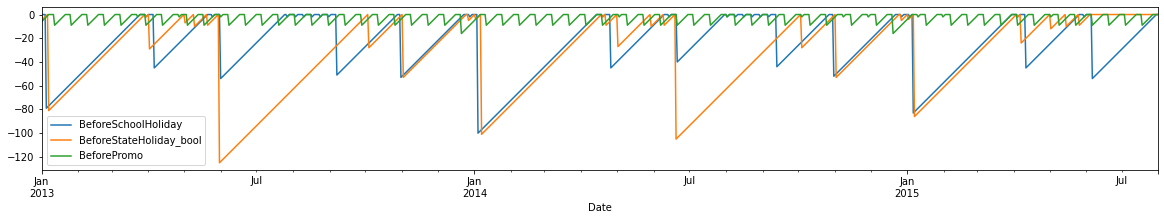

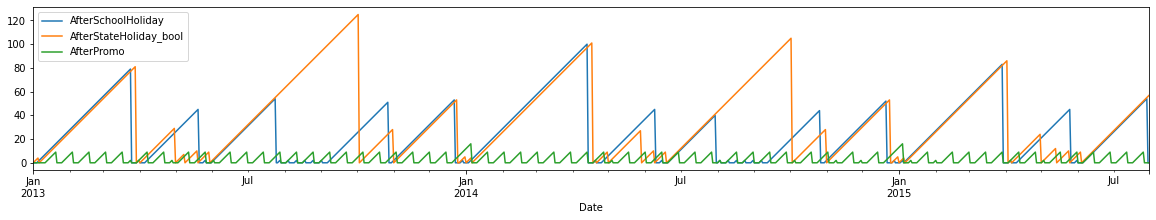

In [ ]:
plt.figure(figsize=(20,3))
df_train[df_train['Store'] == 280]['BeforeSchoolHoliday'].plot()
df_train[df_train['Store'] == 280]['BeforeStateHoliday_bool'].plot()
df_train[df_train['Store'] == 280]['BeforePromo'].plot()
plt.legend()
plt.show()

plt.figure(figsize=(20,3))
df_train[df_train['Store'] == 280]['AfterSchoolHoliday'].plot()
df_train[df_train['Store'] == 280]['AfterStateHoliday_bool'].plot()
df_train[df_train['Store'] == 280]['AfterPromo'].plot()
plt.legend()
plt.show()

Comparamos gráficamente al store 280 con el 500 en cuanto a los dias de promo

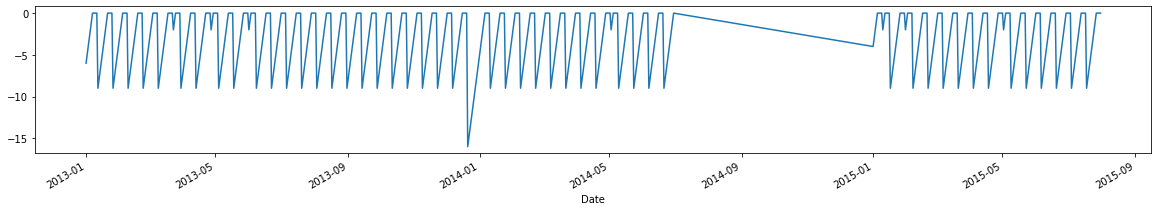

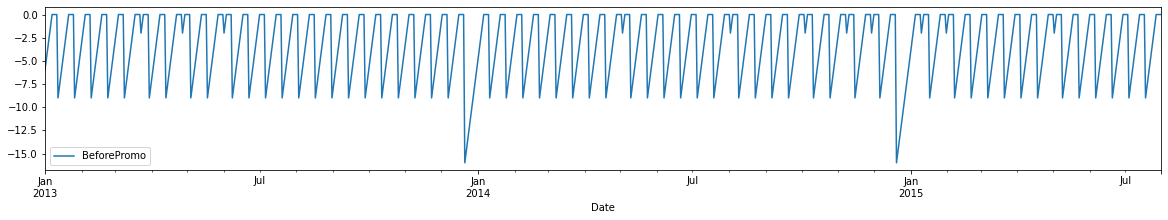

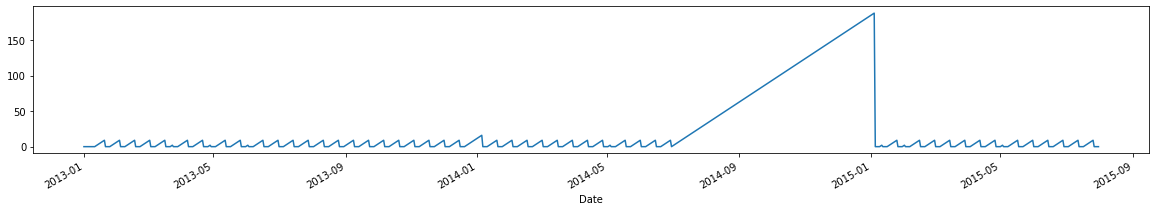

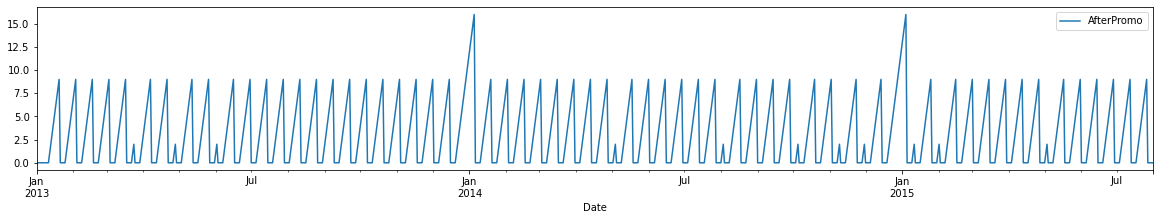

In [ ]:
plt.figure(figsize=(20,3))
(df_train[df_train['Store'] == 500]['BeforePromo']).plot()
plt.figure(figsize=(20,3))
df_train[df_train['Store'] == 280]['BeforePromo'].plot()
plt.legend()
plt.show()

plt.figure(figsize=(20,3))

(df_train[df_train['Store'] == 500]['AfterPromo']).plot()
plt.figure(figsize=(20,3))
df_train[df_train['Store'] == 280]['AfterPromo'].plot()
plt.legend()
plt.show()

## Suavizado de las columnas temporales

Ve que pasa los 7 días antes y los 7 días después para las columnas:
- School Holiday
- State Holiday (StateHoliday_bool)
- Promo
- Close (Close_bool)

Cuenta la cantidad de promos y feriados que hubo los 7 días antes (bwd: backward days) y después del registro (fwd: forward days) para cada una de las fechas.

In [ ]:
df_train[df_train[['Store']+columns]['Store'] == 1].sort_values('Date').head(20)

,Store,Promo,StateHoliday_bool,SchoolHoliday,Close_bool,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday_bool,BeforeStateHoliday_bool,AfterPromo,BeforePromo,AfterClose_bool,BeforeClose_bool
Date,,,,,,,,,,,,,
2013-01-01,1,0,True,1,True,0,0,0,0,0,-6,0,0
2013-01-02,1,0,False,1,False,0,0,1,-86,0,-5,1,-4
2013-01-03,1,0,False,1,False,0,0,2,-85,0,-4,2,-3
2013-01-04,1,0,False,1,False,0,0,3,-84,0,-3,3,-2
2013-01-05,1,0,False,1,False,0,0,4,-83,0,-2,4,-1
2013-01-06,1,0,False,1,True,0,0,5,-82,0,-1,0,0
2013-01-07,1,1,False,1,False,0,0,6,-81,0,0,1,-6
2013-01-08,1,1,False,1,False,0,0,7,-80,0,0,2,-5
2013-01-09,1,1,False,1,False,0,0,8,-79,0,0,3,-4


#### Para bwd

In [ ]:
bwd_train = df_train[['Store']+columns].sort_index().groupby("Store").rolling(7, min_periods=1).sum()
bwd_test = df_test[['Store']+columns].sort_index().groupby("Store").rolling(7, min_periods=1).sum()
bwd_train.head(20)

Store  SchoolHoliday  StateHoliday_bool  Promo  Close_bool
Store Date                                                                  
1     2013-01-01    1.0            1.0                1.0    0.0         1.0
      2013-01-02    2.0            2.0                1.0    0.0         1.0
      2013-01-03    3.0            3.0                1.0    0.0         1.0
      2013-01-04    4.0            4.0                1.0    0.0         1.0
      2013-01-05    5.0            5.0                1.0    0.0         1.0
      2013-01-06    6.0            6.0                1.0    0.0         2.0
      2013-01-07    7.0            7.0                1.0    1.0         2.0
      2013-01-08    7.0            7.0                0.0    2.0         1.0
      2013-01-09    7.0            7.0                0.0    3.0         1.0
      2013-01-10    7.0            7.0                0.0    4.0         1.0
      2013-01-11    7.0            7.0                0.0    5.0         1.0
      2013-01-12    7.0            6.0                0.0    5.0         1.0
      2013-01-13    7.0            5.0                0.0    5.0         1.0
      2013-01-14    7.0            4.0                0.0    4.0         1.0
      2013-01-15    7.0            3.0                0.0    3.0         1.0
      2013-01-16    7.0            2.0                0.0    2.0         1.0
      2013-01-17    7.0            1.0                0.0    1.0         1.0
      2013-01-18    7.0            0.0                0.0    0.0         1.0
      2013-01-19    7.0            0.0                0.0    0.0         1.0
      2013-01-20    7.0            0.0                0.0    0.0         1.0

Como hicimos el rolling para Store también, para que nos quede correctamente a que store pertenece, se lo corregimos abajo:

In [ ]:
bwd_train.drop('Store',1,inplace=True)
bwd_train.reset_index(inplace=True)
bwd_test.drop('Store',1,inplace=True)
bwd_test.reset_index(inplace=True)

In [ ]:
bwd_train.head(20)

,Store,Date,SchoolHoliday,StateHoliday_bool,Promo,Close_bool
0,1,2013-01-01,1.0,1.0,0.0,1.0
1,1,2013-01-02,2.0,1.0,0.0,1.0
2,1,2013-01-03,3.0,1.0,0.0,1.0
3,1,2013-01-04,4.0,1.0,0.0,1.0
4,1,2013-01-05,5.0,1.0,0.0,1.0
5,1,2013-01-06,6.0,1.0,0.0,2.0
6,1,2013-01-07,7.0,1.0,1.0,2.0
7,1,2013-01-08,7.0,0.0,2.0,1.0
8,1,2013-01-09,7.0,0.0,3.0,1.0
9,1,2013-01-10,7.0,0.0,4.0,1.0


#### Para fwd

In [ ]:
fwd_train = df_train[['Store']+columns].sort_index(ascending=False).groupby("Store").rolling(7, min_periods=1).sum()
fwd_test = df_test[['Store']+columns].sort_index(ascending=False).groupby("Store").rolling(7, min_periods=1).sum()

In [ ]:
fwd_train.head(20)

Store  SchoolHoliday  StateHoliday_bool  Promo  Close_bool
Store Date                                                                  
1     2015-07-31    1.0            1.0                0.0    1.0         0.0
      2015-07-30    2.0            2.0                0.0    2.0         0.0
      2015-07-29    3.0            3.0                0.0    3.0         0.0
      2015-07-28    4.0            4.0                0.0    4.0         0.0
      2015-07-27    5.0            5.0                0.0    5.0         0.0
      2015-07-26    6.0            5.0                0.0    5.0         1.0
      2015-07-25    7.0            5.0                0.0    5.0         1.0
      2015-07-24    7.0            4.0                0.0    4.0         1.0
      2015-07-23    7.0            3.0                0.0    3.0         1.0
      2015-07-22    7.0            2.0                0.0    2.0         1.0
      2015-07-21    7.0            1.0                0.0    1.0         1.0
      2015-07-20    7.0            0.0                0.0    0.0         1.0
      2015-07-19    7.0            0.0                0.0    0.0         1.0
      2015-07-18    7.0            0.0                0.0    0.0         1.0
      2015-07-17    7.0            0.0                0.0    1.0         1.0
      2015-07-16    7.0            0.0                0.0    2.0         1.0
      2015-07-15    7.0            0.0                0.0    3.0         1.0
      2015-07-14    7.0            0.0                0.0    4.0         1.0
      2015-07-13    7.0            0.0                0.0    5.0         1.0
      2015-07-12    7.0            0.0                0.0    5.0         1.0

In [ ]:
fwd_train.drop('Store',1,inplace=True)
fwd_train.reset_index(inplace=True)
fwd_test.drop('Store',1,inplace=True)
fwd_test.reset_index(inplace=True)

In [ ]:
df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)

#### Unimos estos valores bwd y fwd a las tablas df_train y df_test

In [ ]:
df_train = df_train.merge(bwd_train, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df_train = df_train.merge(fwd_train, 'left', ['Date', 'Store'], suffixes=['', '_fw'])
df_test = df_test.merge(bwd_test, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df_test = df_test.merge(fwd_test, 'left', ['Date', 'Store'], suffixes=['', '_fw'])

Le dejamos solamente las nuevas caracterísiticas

In [ ]:
df_train.drop(columns,1,inplace=True)
df_test.drop(columns,1,inplace=True)

In [ ]:
df_train.head()

,Date,Store,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday_bool,BeforeStateHoliday_bool,AfterPromo,BeforePromo,AfterClose_bool,BeforeClose_bool,SchoolHoliday_bw,StateHoliday_bool_bw,Promo_bw,Close_bool_bw,SchoolHoliday_fw,StateHoliday_bool_fw,Promo_fw,Close_bool_fw
0,2015-07-31,1,0,0,57,0,0,0,5,0,5.0,0.0,5.0,1.0,1.0,0.0,1.0,0.0
1,2015-07-30,1,0,0,56,0,0,0,4,0,4.0,0.0,4.0,1.0,2.0,0.0,2.0,0.0
2,2015-07-29,1,0,0,55,0,0,0,3,0,3.0,0.0,3.0,1.0,3.0,0.0,3.0,0.0
3,2015-07-28,1,0,0,54,0,0,0,2,0,2.0,0.0,2.0,1.0,4.0,0.0,4.0,0.0
4,2015-07-27,1,0,0,53,0,0,0,1,0,1.0,0.0,1.0,1.0,5.0,0.0,5.0,0.0


#### Pasamos los dates a formato datetime:

In [ ]:
df_train["Date"] = pd.to_datetime(df_train.Date)
df_test["Date"] = pd.to_datetime(df_test.Date)

In [ ]:
df_train.head()

,Date,Store,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday_bool,BeforeStateHoliday_bool,AfterPromo,BeforePromo,AfterClose_bool,BeforeClose_bool,SchoolHoliday_bw,StateHoliday_bool_bw,Promo_bw,Close_bool_bw,SchoolHoliday_fw,StateHoliday_bool_fw,Promo_fw,Close_bool_fw
0,2015-07-31,1,0,0,57,0,0,0,5,0,5.0,0.0,5.0,1.0,1.0,0.0,1.0,0.0
1,2015-07-30,1,0,0,56,0,0,0,4,0,4.0,0.0,4.0,1.0,2.0,0.0,2.0,0.0
2,2015-07-29,1,0,0,55,0,0,0,3,0,3.0,0.0,3.0,1.0,3.0,0.0,3.0,0.0
3,2015-07-28,1,0,0,54,0,0,0,2,0,2.0,0.0,2.0,1.0,4.0,0.0,4.0,0.0
4,2015-07-27,1,0,0,53,0,0,0,1,0,1.0,0.0,1.0,1.0,5.0,0.0,5.0,0.0


Visualizamos la data para before y after

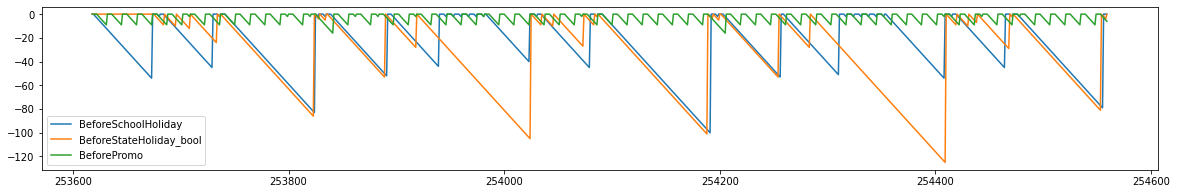

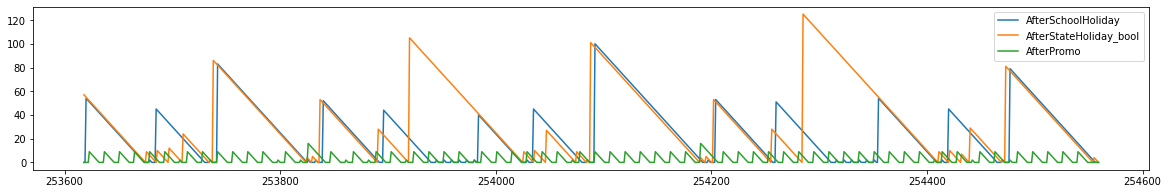

In [ ]:
plt.figure(figsize=(20,3))
df_train[df_train['Store'] == 280]['BeforeSchoolHoliday'].plot()
df_train[df_train['Store'] == 280]['BeforeStateHoliday_bool'].plot()
df_train[df_train['Store'] == 280]['BeforePromo'].plot()
plt.legend()
plt.show()

plt.figure(figsize=(20,3))
df_train[df_train['Store'] == 280]['AfterSchoolHoliday'].plot()
df_train[df_train['Store'] == 280]['AfterStateHoliday_bool'].plot()
df_train[df_train['Store'] == 280]['AfterPromo'].plot()
plt.legend()
plt.show()

In [ ]:
df_train.shape

(1017209, 18)

In [ ]:
df_test.shape

(41088, 18)

### Unimos df_train y df_test a joined_train y joined_test

In [ ]:
joined_train = join_df(joined_train, df_train, ['Store', 'Date'])
joined_test = join_df(joined_test, df_test, ['Store', 'Date'])

In [ ]:
joined_train.shape

(1017209, 86)

In [ ]:
joined_test.shape

(41088, 85)

Guardamos la tabla con todas las características de preprocesamiento

In [ ]:
joined_train.to_feather('/gdrive/Shareddrives/Redes neuronales/TP2/data preprecesada/all_preprocessed_train.fth')

In [ ]:
joined_test.to_feather('/gdrive/Shareddrives/Redes neuronales/TP2/data preprecesada/all_preprocessed_test.fth')

Vemos los días que hubo feriados y promos, además, observamos la suma de la cantidad de feriados y promos de los 7 días anteriores y posteriores (incluyendo el actual) para el store 280 para cada fecha del registro:

Text(0.5, 1.0, 'Promo')

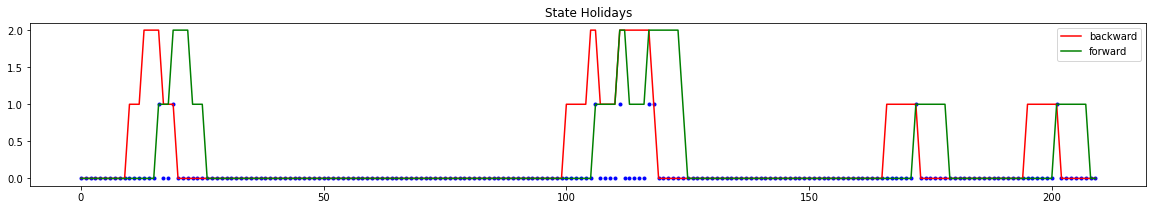

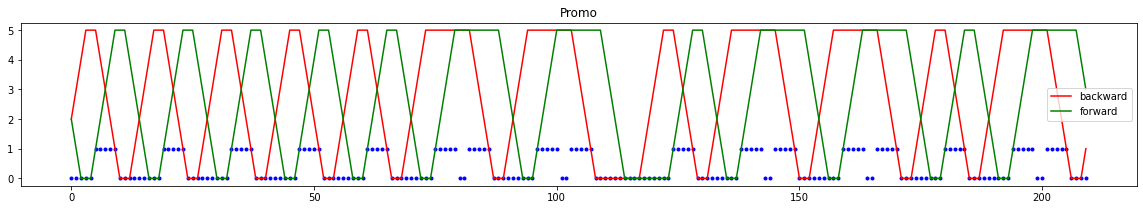

In [ ]:
plt.figure(figsize=(20,3))
plt.plot(joined_train[joined_train['Store']==280]['StateHoliday_bool'].values[100:310]*1.0, c='b', marker='.', linestyle='None')
plt.plot(joined_train[joined_train['Store']==280]['StateHoliday_bool_bw'].values[100:310]*1.0, c='r', label='backward')
plt.plot(joined_train[joined_train['Store']==280]['StateHoliday_bool_fw'].values[100:310]*1.0, c='g', label='forward')
plt.legend()
plt.title('State Holidays')
plt.figure(figsize=(20,3))
plt.plot(joined_train[joined_train['Store']==280]['Promo'].values[100:310]*1.0, c='b', marker='.', linestyle='None')
plt.plot(joined_train[joined_train['Store']==280]['Promo_bw'].values[100:310]*1.0, c='r', label='backward')
plt.plot(joined_train[joined_train['Store']==280]['Promo_fw'].values[100:310]*1.0, c='g', label='forward')
plt.legend()
plt.title('Promo')

In [ ]:
joined_train

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Week,Day,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpenSince,Promo2Since,State,file,week,trend,Date_y,Month_y,Day_y,file_DE,week_DE,trend_DE,Date_DE,State_DE,Month_DE,Day_DE,file_y,Max_TemperatureC,...,Mean_Humidity,Min_Humidity,Max_Sea_Level_PressurehPa,Mean_Sea_Level_PressurehPa,Min_Sea_Level_PressurehPa,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees,StateName,Year_y,Week_y,CompetitionDaysOpen,CompetitionMonthsOpen,Promo2Days,Promo2Weeks,StateHoliday_bool,Close_bool,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday_bool,BeforeStateHoliday_bool,AfterPromo,BeforePromo,AfterClose_bool,BeforeClose_bool,SchoolHoliday_bw,StateHoliday_bool_bw,Promo_bw,Close_bool_bw,SchoolHoliday_fw,StateHoliday_bool_fw,Promo_fw,Close_bool_fw
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,7,31,31,c,a,1270.0,9,2008,0,1,1990,-,2008-09-15,1990-01-01,HE,Rossmann_DE_HE,2015-08-02 - 2015-08-08,85,2015-08-02,8,2,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,None,8,2,Hessen,23,...,54,18,1021,1018,1015,31.0,15.0,10.0,24,11,21.0,0.00,1.0,Fog,13,Hessen,2015,31,2510,24,9342,25,False,False,0,0,57,0,0,0,5,0,5.0,0.0,5.0,1.0,1.0,0.0,1.0,0.0
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,7,31,31,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",2007-11-15,2010-03-29,TH,Rossmann_DE_TH,2015-08-02 - 2015-08-08,80,2015-08-02,8,2,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,None,8,2,Thueringen,19,...,62,25,1021,1019,1017,10.0,10.0,10.0,14,11,21.0,0.00,4.0,Fog,309,Thueringen,2015,31,2815,24,1950,25,False,False,0,0,67,0,0,0,5,0,5.0,0.0,5.0,1.0,1.0,0.0,1.0,0.0
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,7,31,31,a,a,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",2006-12-15,2011-04-04,NW,Rossmann_DE_NW,2015-08-02 - 2015-08-08,86,2015-08-02,8,2,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,None,8,2,NordrheinWestfalen,21,...,61,24,1022,1019,1017,31.0,14.0,10.0,14,5,21.0,0.00,2.0,Fog,354,NordrheinWestfalen,2015,31,3150,24,1579,25,False,False,0,0,57,0,0,0,5,0,5.0,0.0,5.0,1.0,1.0,0.0,1.0,0.0
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,7,31,31,c,c,620.0,9,2009,0,1,1990,-,2009-09-15,1990-01-01,BE,Rossmann_DE_BE,2015-08-02 - 2015-08-08,74,2015-08-02,8,2,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,None,8,2,Berlin,19,...,61,30,1019,1017,1014,10.0,10.0,10.0,23,16,21.0,0.00,6.0,Sunny,282,Berlin,2015,31,2145,24,9342,25,False,False,0,0,67,0,0,0,5,0,5.0,0.0,5.0,1.0,1.0,0.0,1.0,0.0
4,5,5,2015-07-31,4822,559,1,1,0,1,2015,7,31,31,a,a,29910.0,4,2015,0,1,1990,-,2015-04-15,1990-01-01,SN,Rossmann_DE_SN,2015-08-02 - 2015-08-08,82,2015-08-02,8,2,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,None,8,2,Sachsen,20,...,55,26,1020,1018,1016,10.0,10.0,10.0,14,11,21.0,0.00,4.0,Sunny,290,Sachsen,2015,31,107,3,9342,25,False,False,0,0,57,0,0,0,5,0,5.0,0.0,5.0,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,2013,1,1,1,a,a,1900.0,6,2014,1,31,2013,"Jan,Apr,Jul,Oct",2014-06-15,2013-07-29,NW,Rossmann_DE_NW,2013-01-06 - 2013-01-12,63,2013-01-06,1,6,Rossmann_DE,2013-01-06 - 2013-01-12,62,2013-01-06,None,1,6,NordrheinWestfalen,8,...,87,65,1013,1005,1001,31.0,12.0,4.0,39,26,58.0,5.08,6.0,Rain,215,NordrheinWestfalen,2013,1,0,0,0,0,True,True,0,0,0,0,0,-6,0,0,1.0,1.0,0.0,1.0,4.0,1.0,1.0,2.0
1017205,1112,2,2013-01-01,0,0,0,0,a,1,2013,1,1,1,c,c,1880.0,4,2006,0,1,1990,-,2006-04-15,1990-01-01,NW,Rossmann_DE_NW,2013-01-06 - 2013-01-12,63,2013-01-06,1,6,Rossmann_DE,2013-01-06 - 2013-01-12,6

# Normalización y LabelEncode

Hacemos normalización para las variables continuas y label encode para las variables categóricas

## Abrimos los datos preprocesados y chequeamos que se haya hecho correctamente lo anterior

In [ ]:
df_train = pd.read_feather('data preprecesada/all_preprocessed_train.fth')
df_test = pd.read_feather('data preprecesada/all_preprocessed_test.fth')

In [ ]:
df_train.shape, df_test.shape

((1017209, 86), (41088, 85))

Verificamos que se hicieron bien las cosas en test utilizando set() que te devuelve todos los valores únicos de un vector ordenados. En este caso, va a estar devolviendo los nombres de las columnas de df_train y df_test ordenados alfabéticamente. 

In [ ]:
set(df_train.columns)

{'AfterClose_bool',
 'AfterPromo',
 'AfterSchoolHoliday',
 'AfterStateHoliday_bool',
 'Assortment',
 'BeforeClose_bool',
 'BeforePromo',
 'BeforeSchoolHoliday',
 'BeforeStateHoliday_bool',
 'Close_bool',
 'Close_bool_bw',
 'Close_bool_fw',
 'CloudCover',
 'CompetitionDaysOpen',
 'CompetitionDistance',
 'CompetitionMonthsOpen',
 'CompetitionOpenSince',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'Customers',
 'Date',
 'Date_DE',
 'Date_y',
 'Day',
 'DayOfWeek',
 'Day_DE',
 'Day_y',
 'Dew_PointC',
 'Events',
 'Max_Gust_SpeedKm_h',
 'Max_Humidity',
 'Max_Sea_Level_PressurehPa',
 'Max_TemperatureC',
 'Max_VisibilityKm',
 'Max_Wind_SpeedKm_h',
 'MeanDew_PointC',
 'Mean_Humidity',
 'Mean_Sea_Level_PressurehPa',
 'Mean_TemperatureC',
 'Mean_VisibilityKm',
 'Mean_Wind_SpeedKm_h',
 'Min_DewpointC',
 'Min_Humidity',
 'Min_Sea_Level_PressurehPa',
 'Min_TemperatureC',
 'Min_VisibilitykM',
 'Month',
 'Month_DE',
 'Month_y',
 'Open',
 'Precipitationmm',
 'Promo',
 'Promo2',
 'Promo2D

Al restar las columnas del train con el test, vemos que nos devuelve las dos columnas que tenemos que predecir ya que el conjunto test no las tiene. 

In [ ]:
set(df_train.columns) - set(df_test.columns)

{'Customers', 'Sales'}

In [ ]:
(df_train['CompetitionDistance'].isna()).sum()

0

## Vemos las variables categóricas

In [ ]:
 cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day',
             'StateHoliday', 'SchoolHoliday', 'Promo2SinceWeek',
             'CompetitionMonthsOpen', 'Promo2Weeks', 'Promo2',
             'StoreType', 'Assortment', 'PromoInterval', 
             'CompetitionOpenSinceYear', 'Promo2SinceYear', 'State', 
             'Events', 'Week', 'Promo','Promo_fw', 'Promo_bw', 'StateHoliday_bool_fw',
             'StateHoliday_bool_bw', 'SchoolHoliday_fw', 'SchoolHoliday_bw',
             'Close_bool_bw','Close_bool_fw']

Vemos la cantidad de valores que puede tomar cada variable categórica, el tipo y la cantidad de datos faltantes:

In [ ]:
DataFrameSummary(df_train[cat_vars]).summary().loc[['uniques', 'types', 'missing']].T

,uniques,types,missing
Store,1115,numeric,0
DayOfWeek,7,numeric,0
Year,3,numeric,0
Month,12,numeric,0
Day,31,numeric,0
StateHoliday,4,categorical,0
SchoolHoliday,2,bool,0
Promo2SinceWeek,24,numeric,0
CompetitionMonthsOpen,25,numeric,0
Promo2Weeks,26,numeric,0


## Vemos las variables continuas

In [ ]:
df_train.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Week', 'Day',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval',
       'CompetitionOpenSince', 'Promo2Since', 'State', 'file', 'week', 'trend',
       'Date_y', 'Month_y', 'Day_y', 'file_DE', 'week_DE', 'trend_DE',
       'Date_DE', 'State_DE', 'Month_DE', 'Day_DE', 'file_y',
       'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
       'Dew_PointC', 'MeanDew_PointC', 'Min_DewpointC', 'Max_Humidity',
       'Mean_Humidity', 'Min_Humidity', 'Max_Sea_Level_PressurehPa',
       'Mean_Sea_Level_PressurehPa', 'Min_Sea_Level_PressurehPa',
       'Max_VisibilityKm', 'Mean_VisibilityKm', 'Min_VisibilitykM',
       'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h', 'Max_Gust_SpeedKm_h',
       'Precipitationmm', 'Cl

In [ ]:
contin_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 
               'Min_TemperatureC', 'Precipitationmm',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday_bool', 'BeforeStateHoliday_bool',
    'AfterPromo','BeforePromo', 'StateHoliday_bool','AfterSchoolHoliday','BeforeSchoolHoliday',
   'AfterClose_bool','BeforeClose_bool']

In [ ]:
len(contin_vars) + len(cat_vars)

50

In [ ]:
len(df_train.columns)

86

In [ ]:
DataFrameSummary(df_train[contin_vars]).summary().loc[['uniques', 'types', 'missing']].T

,uniques,types,missing
CompetitionDistance,654,numeric,0
Max_TemperatureC,50,numeric,0
Mean_TemperatureC,45,numeric,0
Min_TemperatureC,40,numeric,0
Precipitationmm,40,numeric,0
Max_Humidity,52,numeric,0
Mean_Humidity,71,numeric,0
Min_Humidity,93,numeric,0
Max_Wind_SpeedKm_h,42,numeric,0
Mean_Wind_SpeedKm_h,27,numeric,0


## Normalización en continuas y LabelEncode en categóricas

###Para variables categóricas

Con LabelEncoder() codificamos las etiquetas categoricas (labels) con un valor entre 0 y n_classes-1.



In [ ]:
cat_maps = [(o, LabelEncoder()) for o in cat_vars]

In [ ]:
cat_maps

[('Store', LabelEncoder()),
 ('DayOfWeek', LabelEncoder()),
 ('Year', LabelEncoder()),
 ('Month', LabelEncoder()),
 ('Day', LabelEncoder()),
 ('StateHoliday', LabelEncoder()),
 ('SchoolHoliday', LabelEncoder()),
 ('Promo2SinceWeek', LabelEncoder()),
 ('CompetitionMonthsOpen', LabelEncoder()),
 ('Promo2Weeks', LabelEncoder()),
 ('Promo2', LabelEncoder()),
 ('StoreType', LabelEncoder()),
 ('Assortment', LabelEncoder()),
 ('PromoInterval', LabelEncoder()),
 ('CompetitionOpenSinceYear', LabelEncoder()),
 ('Promo2SinceYear', LabelEncoder()),
 ('State', LabelEncoder()),
 ('Events', LabelEncoder()),
 ('Week', LabelEncoder()),
 ('Promo', LabelEncoder()),
 ('Promo_fw', LabelEncoder()),
 ('Promo_bw', LabelEncoder()),
 ('StateHoliday_bool_fw', LabelEncoder()),
 ('StateHoliday_bool_bw', LabelEncoder()),
 ('SchoolHoliday_fw', LabelEncoder()),
 ('SchoolHoliday_bw', LabelEncoder()),
 ('Close_bool_bw', LabelEncoder()),
 ('Close_bool_fw', LabelEncoder())]

In [ ]:
mapper_cat = DataFrameMapper(cat_maps)
_ = mapper_cat.fit(df_train) #fiteamos labelEncoder

Mostramos como codifica cada una de las categorías de las variables categóricas:

In [ ]:
N = 10
print(list(zip(df_train['Assortment'].values[:N], mapper_cat.transform(df_train)[:,9][:N])))# Assortment es la novena posición en cat_maps
print(list(zip(df_train['Events'].values[:N], mapper_cat.transform(df_train)[:,15][:N])))
print(list(zip(df_train['Year'].values[:N], mapper_cat.transform(df_train)[:,2][:N])))

[('a', 25), ('a', 25), ('a', 25), ('c', 25), ('a', 25), ('a', 25), ('c', 25), ('a', 25), ('c', 25), ('a', 25)]
[('Fog', 0), ('Fog', 2), ('Fog', 3), ('Sunny', 0), ('Sunny', 0), ('Sunny', 0), ('Rain', 0), ('Rain', 0), ('Fog', 0), ('Sunny', 0)]
[(2015, 2), (2015, 2), (2015, 2), (2015, 2), (2015, 2), (2015, 2), (2015, 2), (2015, 2), (2015, 2), (2015, 2)]


Cuando se entrene el modelo en sí, se lo va a hacer con la codificación mostrada, por lo que lo hacemos con todas:

In [ ]:
df_train[cat_vars] = mapper_cat.transform(df_train)
df_test[cat_vars] = mapper_cat.transform(df_test)

### Para variables continuas

Con StandardScaler() normalizamos las variables continuas siguiendo la siguiente fórmula:
$$z = \frac{x-\mu}{s}$$


In [ ]:
contin_maps = [([o], StandardScaler()) for o in contin_vars]

In [ ]:
mapper_cont = DataFrameMapper(contin_maps)
_ = mapper_cont.fit(df_train)

Mostramos como quedan los valores normalizados para las variables continuas:

In [ ]:
N = 10
print(df_train['CompetitionDistance'].values[:N])
print(mapper_cont.transform(df_train)[:, 0][:N])

[ 1270.   570. 14130.   620. 29910.   310. 24000.  7520.  2030.  3160.]
[-0.51104292 -0.59341201  1.00219483 -0.5875285   2.85902934 -0.62400624
  2.16359893  0.22439533 -0.42161363 -0.28864639]


In [ ]:
df_train[contin_vars] = mapper_cont.transform(df_train)
df_test[contin_vars] = mapper_cont.transform(df_test)

In [ ]:
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Week,Day,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpenSince,Promo2Since,State,file,week,trend,Date_y,Month_y,Day_y,file_DE,week_DE,trend_DE,Date_DE,State_DE,Month_DE,Day_DE,file_y,Max_TemperatureC,...,Mean_Humidity,Min_Humidity,Max_Sea_Level_PressurehPa,Mean_Sea_Level_PressurehPa,Min_Sea_Level_PressurehPa,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees,StateName,Year_y,Week_y,CompetitionDaysOpen,CompetitionMonthsOpen,Promo2Days,Promo2Weeks,StateHoliday_bool,Close_bool,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday_bool,BeforeStateHoliday_bool,AfterPromo,BeforePromo,AfterClose_bool,BeforeClose_bool,SchoolHoliday_bw,StateHoliday_bool_bw,Promo_bw,Close_bool_bw,SchoolHoliday_fw,StateHoliday_bool_fw,Promo_fw,Close_bool_fw
0,0,4,2015-07-31,5263,555,1,1,0,1,2,6,30,30,2,0,-0.511043,9,13,0,0,0,0,2008-09-15,1990-01-01,4,Rossmann_DE_HE,2015-08-02 - 2015-08-08,1.744361,2015-08-02,8,2,Rossmann_DE,2015-08-02 - 2015-08-08,1.743049,2015-08-02,None,8,2,Hessen,1.024446,...,-1.510789,-1.626560,1021,1018,1015,31.0,15.0,10.0,0.148437,-0.147662,21.0,-0.315778,-1.859165,0,13,Hessen,2015,31,2510,24,9342,25,-0.177442,False,-1.060264,1.010611,0.644376,1.072424,-0.545071,0.935012,-0.018204,0.387921,5,0,5,1,1,0,1,0
1,1,4,2015-07-31,6064,625,1,1,0,1,2,6,30,30,0,0,-0.593412,11,12,1,5,2,2,2007-11-15,2010-03-29,11,Rossmann_DE_TH,2015-08-02 - 2015-08-08,1.303439,2015-08-02,8,2,Rossmann_DE,2015-08-02 - 2015-08-08,1.743049,2015-08-02,None,8,2,Thueringen,0.551899,...,-0.905024,-1.269897,1021,1019,1017,10.0,10.0,10.0,-0.970080,-0.147662,21.0,-0.315778,-0.493858,0,309,Thueringen,2015,31,2815,24,1950,25,-0.177442,False,-1.060264,1.010611,0.965073,1.072424,-0.545071,0.935012,-0.018204,0.387921,5,0,5,1,1,0,1,0
2,2,4,2015-07-31,8314,821,1,1,0,1,2,6,30,30,0,0,1.002195,12,11,1,6,3,2,2006-12-15,2011-04-04,6,Rossmann_DE_NW,2015-08-02 - 2015-08-08,1.832546,2015-08-02,8,2,Rossmann_DE,2015-08-02 - 2015-08-08,1.743049,2015-08-02,None,8,2,NordrheinWestfalen,0.788172,...,-0.980745,-1.320848,1022,1019,1017,31.0,14.0,10.0,-0.970080,-1.165096,21.0,-0.315778,-1.404063,0,354,NordrheinWestfalen,2015,31,3150,24,1579,25,-0.177442,False,-1.060264,1.010611,0.644376,1.072424,-0.545071,0.935012,-0.018204,0.387921,5,0,5,1,1,0,1,0
3,3,4,2015-07-31,13995,1498,1,1,0,1,2,6,30,30,2,2,-0.587528,9,14,0,0,0,0,2009-09-15,1990-01-01,0,Rossmann_DE_BE,2015-08-02 - 2015-08-08,0.774331,2015-08-02,8,2,Rossmann_DE,2015-08-02 - 2015-08-08,1.743049,2015-08-02,None,8,2,Berlin,0.551899,...,-0.980745,-1.015137,1019,1017,1014,10.0,10.0,10.0,0.036585,0.700200,21.0,-0.315778,0.416347,20,282,Berlin,2015,31,2145,24,9342,25,-0.177442,False,-1.060264,1.010611,0.965073,1.072424,-0.545071,0.935012,-0.018204,0.387921,5,0,5,1,1,0,1,0
4,4,4,2015-07-31,4822,559,1,1,0,1,2,6,30,30,0,0,2.859029,4,20,0,0,0,0,2015-04-15,1990-01-01,9,Rossmann_DE_SN,2015-08-02 - 2015-08-08,1.479808,2015-08-02,8,2,Rossmann_DE,2015-08-02 - 2015-08-08,1.743049,2015-08-02,None,8,2,Sachsen,0.670036,...,-1.435069,-1.218945,1020,1018,1016,10.0,10.0,10.0,-0.970080,-0.147662,21.0,-0.315778,-0.493858,20,290,Sachsen,2015,31,107,3,9342,25,-0.177442,False,-1.060264,1.010611,0.644376,1.072424,-0.545071,0.935012,-0.018204,0.387921,5,0,5,1,1,0,1,0


In [ ]:
DataFrameSummary(df_train[cat_vars]).summary().loc[['uniques', 'types']]

,Store,DayOfWeek,Year,Month,Day,StateHoliday,SchoolHoliday,Promo2SinceWeek,CompetitionMonthsOpen,Promo2Weeks,Promo2,StoreType,Assortment,PromoInterval,CompetitionOpenSinceYear,Promo2SinceYear,State,Events,Week,Promo,Promo_fw,Promo_bw,StateHoliday_bool_fw,StateHoliday_bool_bw,SchoolHoliday_fw,SchoolHoliday_bw,Close_bool_bw,Close_bool_fw
uniques,1115,7,3,12,31,4,2,24,25,26,2,4,3,4,21,8,12,22,52,2,6,6,3,3,8,8,8,8
types,numeric,numeric,numeric,numeric,numeric,numeric,bool,numeric,numeric,numeric,bool,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,bool,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric


# Final processing

In [ ]:
df_train.shape

(1017209, 86)

Se ve cuantos registros con Sales == 0 hay en nuestro dataset.

In [ ]:
len(df_train[df_train.Sales==0])

172871

Se ve cuantos registros hay cuando la tienda estuvo cerrada.

In [ ]:
len(df_train[df_train.Open==0])

172817

Los autores eliminaron todos los casos en los que la tienda tenía cero ventas o estaba cerrada. Especulamos que esto les puede haber costado una posición más alta en la competencia. 

Nosotros probaremos copiando el procesamiento realizado por el grupo y también conservando esos registros que eliminaron, ya que se cree que antes y después de los periodos, naturalmente hay picos en las ventas que cabría esperar. 

Se sacan Sales == 0, como el grupo del tercer puesto

In [ ]:
df_sales = df_train[df_train.Sales!=0]

In [ ]:
df_sales.shape

(844338, 86)

In [ ]:
df_test.reset_index(inplace=True)
df_train.reset_index(inplace= True)
df_sales.reset_index(inplace=True)

##Agregado de la columna mean_sales_store

Obtengo la media de ventas para cada una de las tiendas:

In [ ]:
stores_mean = {}
for store, g_df in df_train.groupby('Store'):
    stores_mean[store] = g_df[g_df['Sales'] > 0]['Sales'].mean()

Para cada registro, guardo la media de la tienda que correspone a cada registro


In [ ]:
df_train.loc[:, 'mean_by_store'] = df_train['Store'].apply(stores_mean.get)
df_sales.loc[:, 'mean_by_store'] = df_sales['Store'].apply(stores_mean.get)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


Para cada registro, guardo la diferencia entre las ventas reales y las ventas calculadas reemplazando la media de cada tienda

In [ ]:
df_train.loc[:, 'Sales_store'] = df_train['Sales'] - df_train['mean_by_store']
df_sales.loc[:, 'Sales_store'] = df_sales['Sales'] - df_sales['mean_by_store']

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


## Se guardan los datos preprocesados

In [ ]:
df_sales.to_feather('data preprecesada/train_normalized_data_!sales0.fth')
df_test.to_feather('data preprecesada/test_normalized_data.fth')
df_train.to_feather('data preprecesada/train_normalized_data.fth')